<a href="https://colab.research.google.com/github/REDEVL4/Adversarial-Attacks-on-Deep-Neural-Networks/blob/30%25-Dataset-Training/AA_v3_30_Datset_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================================================
# MURA (XR_SHOULDER or full) — PyTorch training with preprocessing,
# progress bars, checkpoints (auto-resume), ResNet50/DenseNet121,
# and GPU via DirectML/CUDA.
# ================================================================
import os, re, time, random, json, math, warnings
from pathlib import Path
from collections import defaultdict, Counter

warnings.filterwarnings("ignore")
# If you ever hit the OpenMP duplicate runtime crash on Windows with OpenCV,
# uncomment the next line (workaround):
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ----------------
# Basic libraries
# ----------------
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

# ================================================================
# 1) Paths & config
# ================================================================
# Point this to the *folder that contains* MURA-v1.1/
# DATA_ROOT = r"C:\Users\reddy\Downloads\Documents\Capstone\Datasets\MURA-v1.1\MURA-v1.1"
DATA_ROOT = r"C:\Users\NaralaG3762\Downloads\MURA-v1.1\MURA-v1.1"
DATA_ROOT = str(Path(DATA_ROOT))          # normalize

# Optional: restrict to one anatomy (e.g., "XR_SHOULDER") or set to None for all
ANATOMY_SUBSET = None

RUN_DIR    = Path(DATA_ROOT) / "AA_v3 testing_t1_dml_runs"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Model/training
MODEL_NAME = "resnet50"            # "resnet50" or "densenet121"
IMG_SIZE   = 320
BATCH_SIZE = 24
EPOCHS     = 500
LR         = 3e-4
PATIENCE   = 3                     # early stopping by val loss
NUM_CLASSES= 2
SEED       = 42

# Checkpoint paths
CHECKPOINT_DIR = RUN_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
LATEST_CKPT    = CHECKPOINT_DIR / "latest.pt"
BEST_PATH      = RUN_DIR / f"{MODEL_NAME}_best.pt"
HISTORY_JSON   = CHECKPOINT_DIR / "history.json"
RESUME         = True
SAVE_EVERY_STEPS = 0  # set >0 to also save mid-epoch (e.g., 1000)

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [ ]:
# ================================================================
# 2) Device selection: DirectML -> CUDA -> CPU
# ================================================================
def pick_device(prefer_gpu=True):
    if prefer_gpu:
        # 1) DirectML (for AMD/Intel GPUs on Windows)
        try:
            import torch_directml
            dml_dev = torch_directml.device()
            # quick sanity check: create a tiny tensor on DML
            _ = torch.randn(1, device=dml_dev)
            print("Using DirectML GPU:", dml_dev)
            return dml_dev
        except Exception:
            pass
        # 2) NVIDIA CUDA
        if torch.cuda.is_available():
            print("Using CUDA GPU:", torch.cuda.get_device_name(0))
            return torch.device("cuda")
    print("Using CPU")
    return torch.device("cpu")

DEVICE = pick_device(prefer_gpu=True)


Using CUDA GPU: Quadro RTX 5000


In [ ]:
# ================================================================
# 3) Scan MURA dataset (train/valid image paths)
#    Uses official folder structure: MURA-v1.1/train/...
# ================================================================
def scan_mura_split(split_root: Path, anatomy_subset=None):
    rows = []
    for part_dir in sorted(split_root.iterdir()):
        if not part_dir.is_dir():
            continue
        if anatomy_subset and part_dir.name != anatomy_subset:
            continue
        for pat in part_dir.iterdir():
            if not pat.is_dir(): continue
            for study in pat.iterdir():
                if not study.is_dir(): continue
                label = 1 if "positive" in study.name.lower() else 0
                for f in study.iterdir():
                    if f.suffix.lower() in {".png", ".jpg", ".jpeg"}:
                        rows.append({"path": str(f), "label": label})
    return pd.DataFrame(rows)

train_root = Path(DATA_ROOT)/"train"
valid_root = Path(DATA_ROOT)/"valid"
assert train_root.exists(), f"Missing: {train_root}"
assert valid_root.exists(), f"Missing: {valid_root}"

train_df = scan_mura_split(train_root, anatomy_subset=ANATOMY_SUBSET)
valid_df = scan_mura_split(valid_root, anatomy_subset=ANATOMY_SUBSET)

print(f"Train images: {len(train_df)}  | Val images: {len(valid_df)}")
print("Label dist (train):", Counter(train_df["label"].tolist()))
print("Label dist (val):  ", Counter(valid_df["label"].tolist()))


Train images: 36812  | Val images: 3197
Label dist (train): Counter({0: 21939, 1: 14873})
Label dist (val):   Counter({0: 1667, 1: 1530})


In [ ]:
# ================================================================
# Clean index: drop AppleDouble files (._*), hidden files, non-images
# ================================================================
from pathlib import Path

VALID_EXTS = {".png", ".jpg", ".jpeg"}

def is_valid_relpath(relp: str) -> bool:
    p = Path(relp)
    name = p.name
    # drop hidden / AppleDouble
    if name.startswith("._") or name.startswith("."):
        return False
    # drop weird extensions
    if p.suffix.lower() not in VALID_EXTS:
        return False
    # ensure the file actually exists on disk
    return Path(DATA_ROOT).joinpath(p).is_file()

def clean_df(df):
    before = len(df)
    df = df[df["path"].map(is_valid_relpath)].copy()
    after = len(df)
    if before != after:
        print(f"[clean_df] removed {before-after} bad rows (._*, hidden, missing, non-image).")
    return df

train_df = clean_df(train_df)
valid_df = clean_df(valid_df)

# ===== After scanning original MURA splits =====
# Combine full pool
combined_df = pd.concat([train_df, valid_df], ignore_index=True)

# Take a STRATIFIED 30% sample of the entire pool
from sklearn.model_selection import train_test_split
SEED_STRATIFY = SEED if "SEED" in globals() else 42

sub_df, _ = train_test_split(
    combined_df,
    train_size=0.30,                     # keep 30% of the whole dataset
    stratify=combined_df["label"],       # preserve class distribution
    random_state=SEED_STRATIFY
)

# Split that 30% into 70/20/10 (train/val/test), stratified
train_df, temp_df = train_test_split(
    sub_df,
    test_size=0.30,                      # 30% of sub_df goes to temp (val+test)
    stratify=sub_df["label"],
    random_state=SEED_STRATIFY
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,                       # 1/3 of temp -> test (≈10% of full); 2/3 -> val (≈20% of full)
    stratify=temp_df["label"],
    random_state=SEED_STRATIFY
)

# IMPORTANT: reset indices so .loc[idx, ...] works with integer idx
for _df in (train_df, val_df, test_df):
    _df.reset_index(drop=True, inplace=True)

print(f"[STRATIFIED 30% POOL] train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
from collections import Counter
print("Label dist (train):", Counter(train_df["label"].tolist()))
print("Label dist (val):  ", Counter(val_df["label"].tolist()))
print("Label dist (test): ", Counter(test_df["label"].tolist()))


[clean_df] removed 4 bad rows (._*, hidden, missing, non-image).
[STRATIFIED 30% POOL] train=8400, val=2400, test=1201
Label dist (train): Counter({0: 4956, 1: 3444})
Label dist (val):   Counter({0: 1416, 1: 984})
Label dist (test):  Counter({0: 708, 1: 493})


In [ ]:
# ================================================================
# 4) Preprocessing transforms (CPU, per-image, OpenCV/Numpy)
#    Order: Bone Windowing -> CLAHE -> Edge Mix -> Auto-crop
# ================================================================
class BoneWindowTransform:
    """Percentile-based windowing to emphasize bone range."""
    def __init__(self, lower_percentile=3, upper_percentile=97):
        self.lp = lower_percentile
        self.hp = upper_percentile
    def __call__(self, img_np):
        f = img_np.astype(np.float32)
        nz = f[f > 0]
        if nz.size == 0: return img_np
        p_low  = np.percentile(nz, self.lp)
        p_high = np.percentile(nz, self.hp)
        if p_high <= p_low: return img_np
        w = np.clip(f, p_low, p_high)
        w = ((w - p_low) / (p_high - p_low) * 255.0).astype(np.uint8)
        return w

class ClaheTransform:
    """Local contrast enhancement."""
    def __init__(self, clip_limit=2.5, tile_grid_size=(8,8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    def __call__(self, img_np):
        return self.clahe.apply(img_np.astype(np.uint8))

class EdgeTransform:
    """Add a fraction of Sobel edge magnitude back to the image."""
    def __init__(self, alpha=0.5):
        self.alpha = float(alpha)
    def __call__(self, img_np):
        img = img_np.astype(np.float32)
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx*gx + gy*gy)
        mag = (mag / (mag.max() + 1e-6)) * 255.0
        out = np.clip(img + self.alpha*mag, 0, 255).astype(np.uint8)
        return out

class AutoCropTransform:
    """Tightly crop to the largest foreground contour; fallback to original if empty."""
    def __init__(self, thresh=5):
        self.thresh = thresh
    def __call__(self, img_np):
        # Threshold
        _, bw = cv2.threshold(img_np, self.thresh, 255, cv2.THRESH_BINARY)
        cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            return img_np
        maxc = max(cnts, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(maxc)
        # avoid too small crops
        if w < 16 or h < 16:
            return img_np
        return img_np[y:y+h, x:x+w]

# Compose pipeline
clahe    = ClaheTransform(clip_limit=2.5, tile_grid_size=(8,8))
window   = BoneWindowTransform(3,97)
edge     = EdgeTransform(alpha=0.5)
autocrop = AutoCropTransform()

def preprocess_chain(img_np):
    x = img_np
    x = window(x)     # 1) windowing
    x = clahe(x)      # 2) CLAHE
    x = edge(x)       # 3) edge mix
    x = autocrop(x)   # 4) auto-crop
    return x


CLAHE sweep…


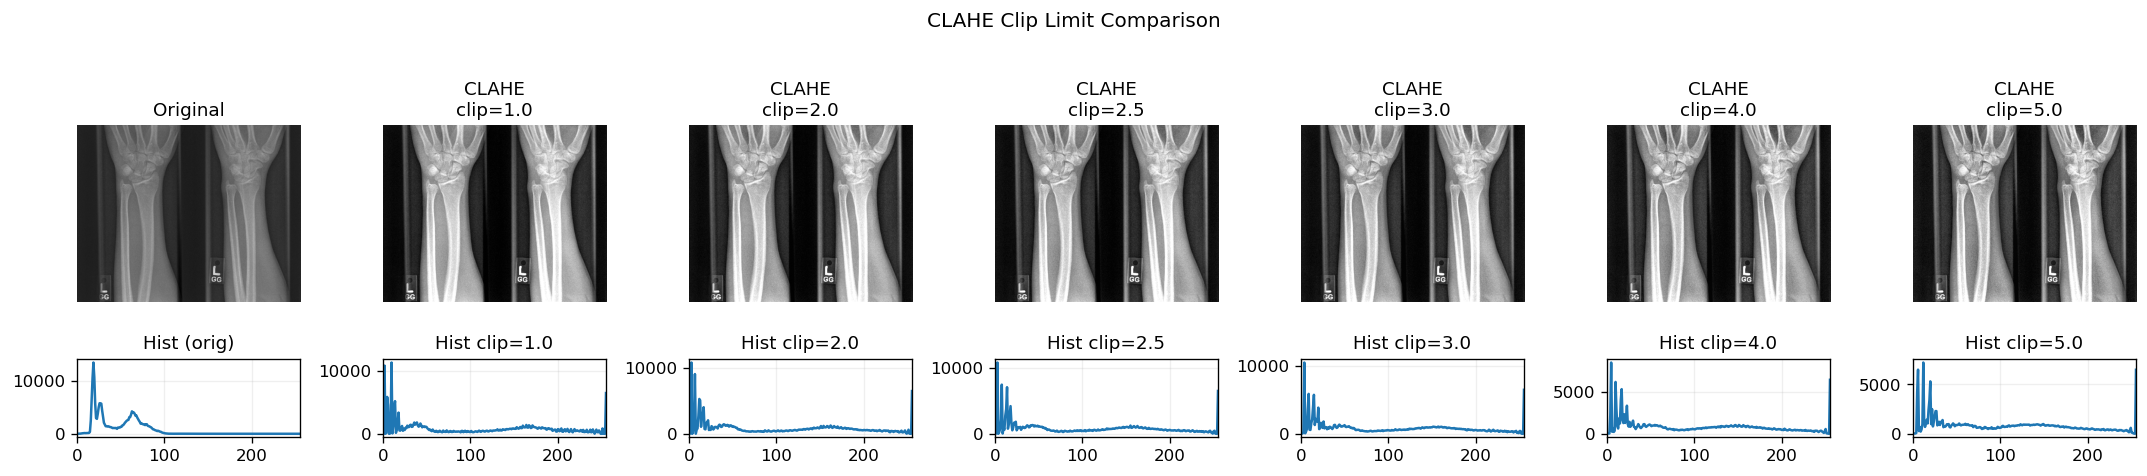

Windowing sweep…


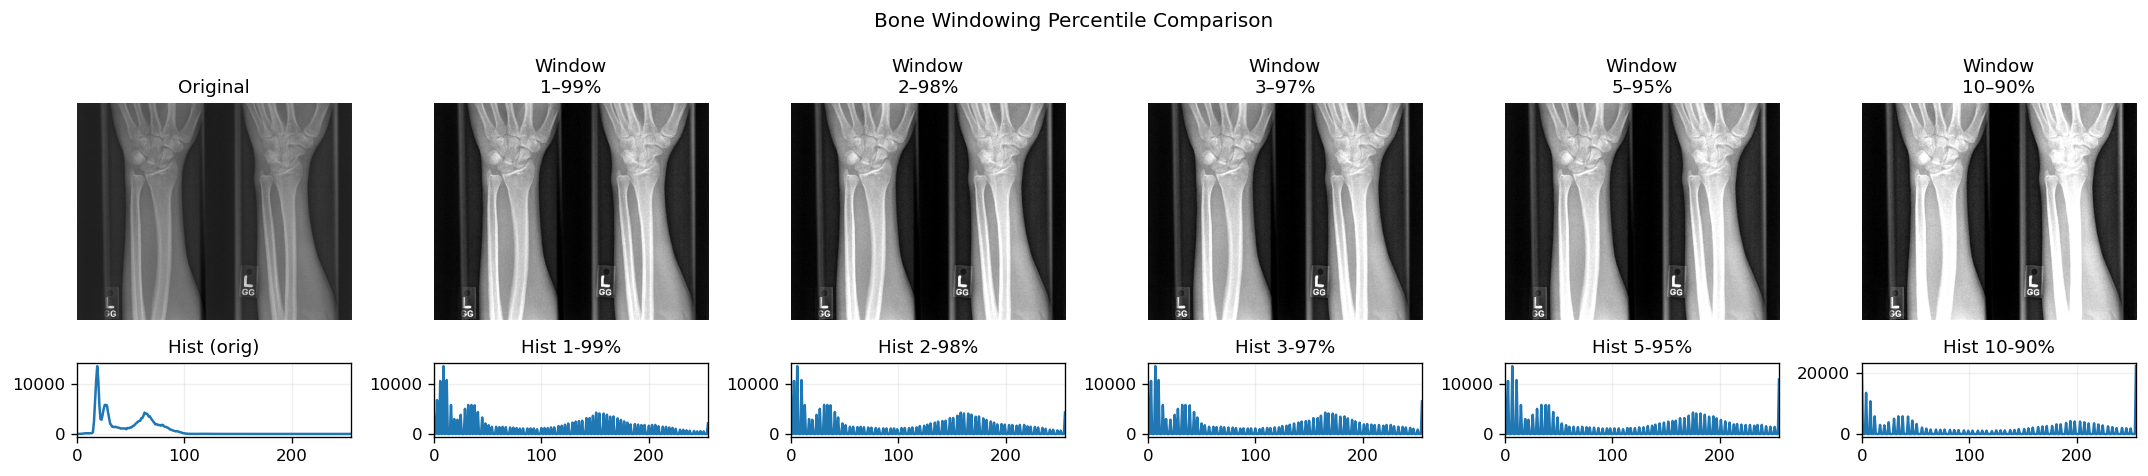

Edge mix sweep…


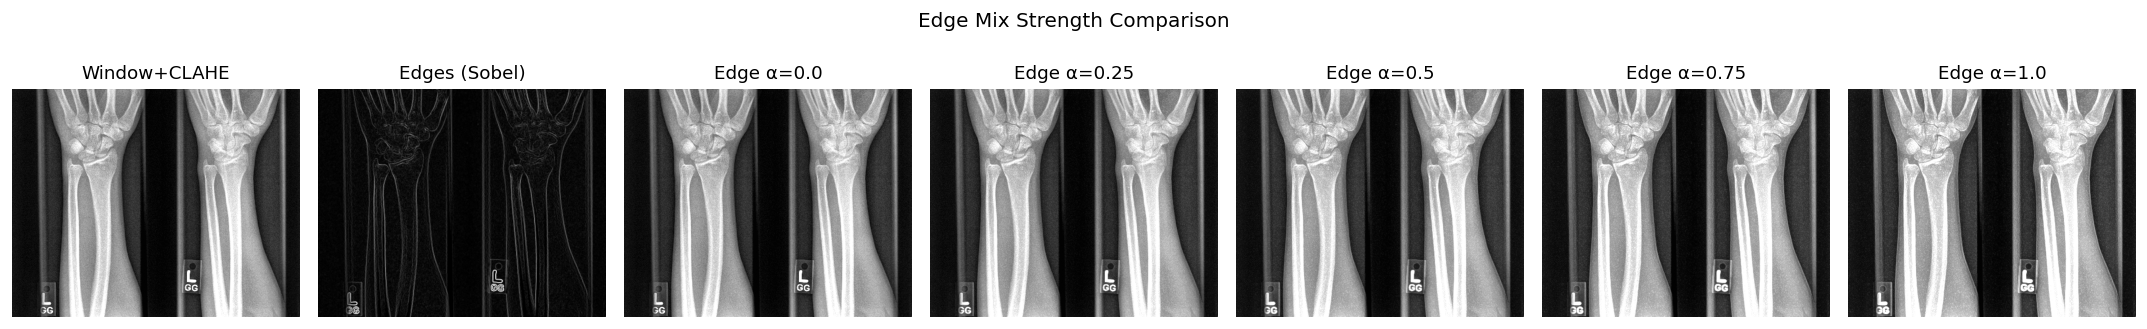

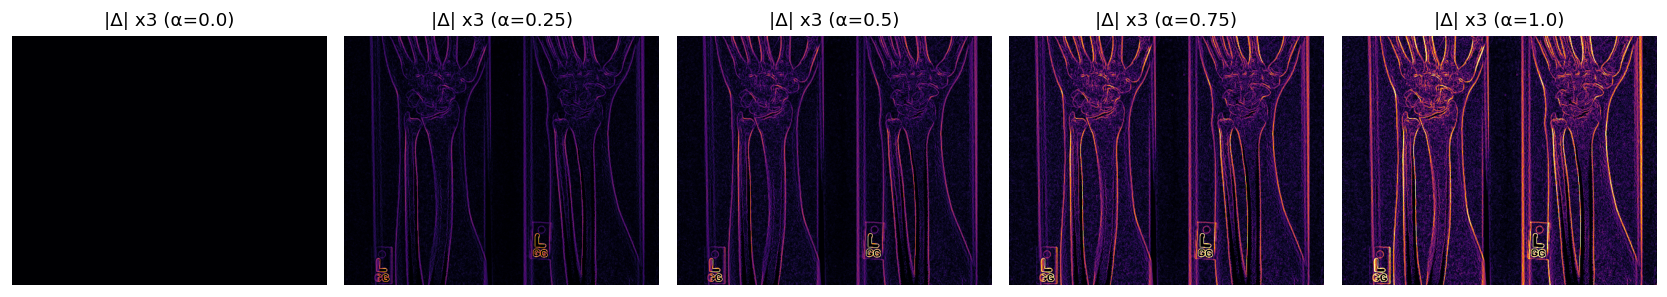

Auto-crop preview…


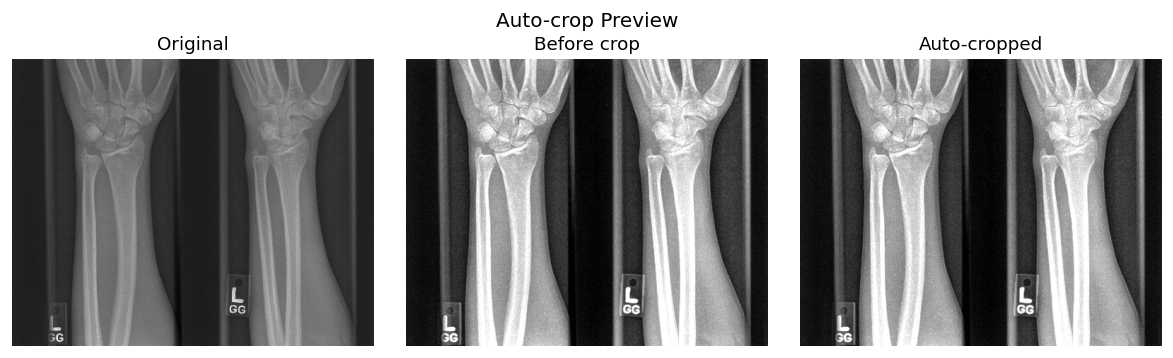

CLAHE sweep…


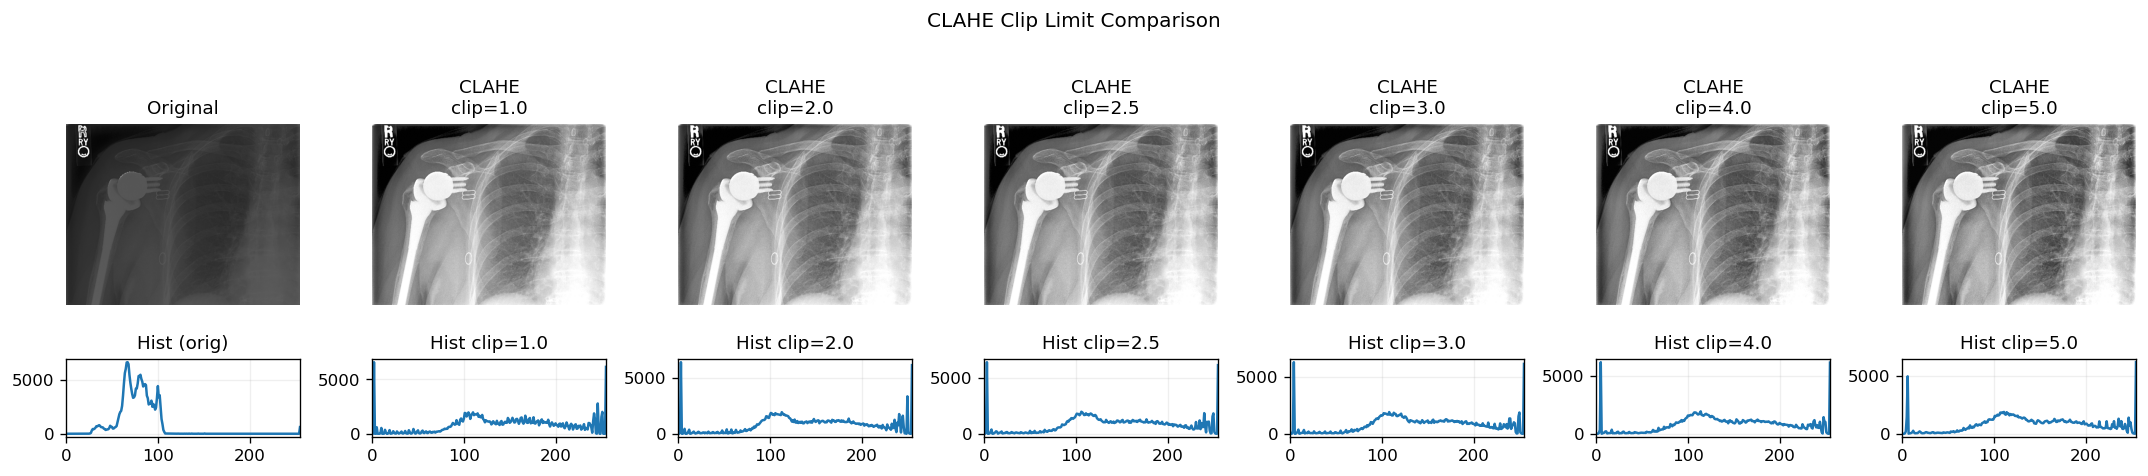

Windowing sweep…


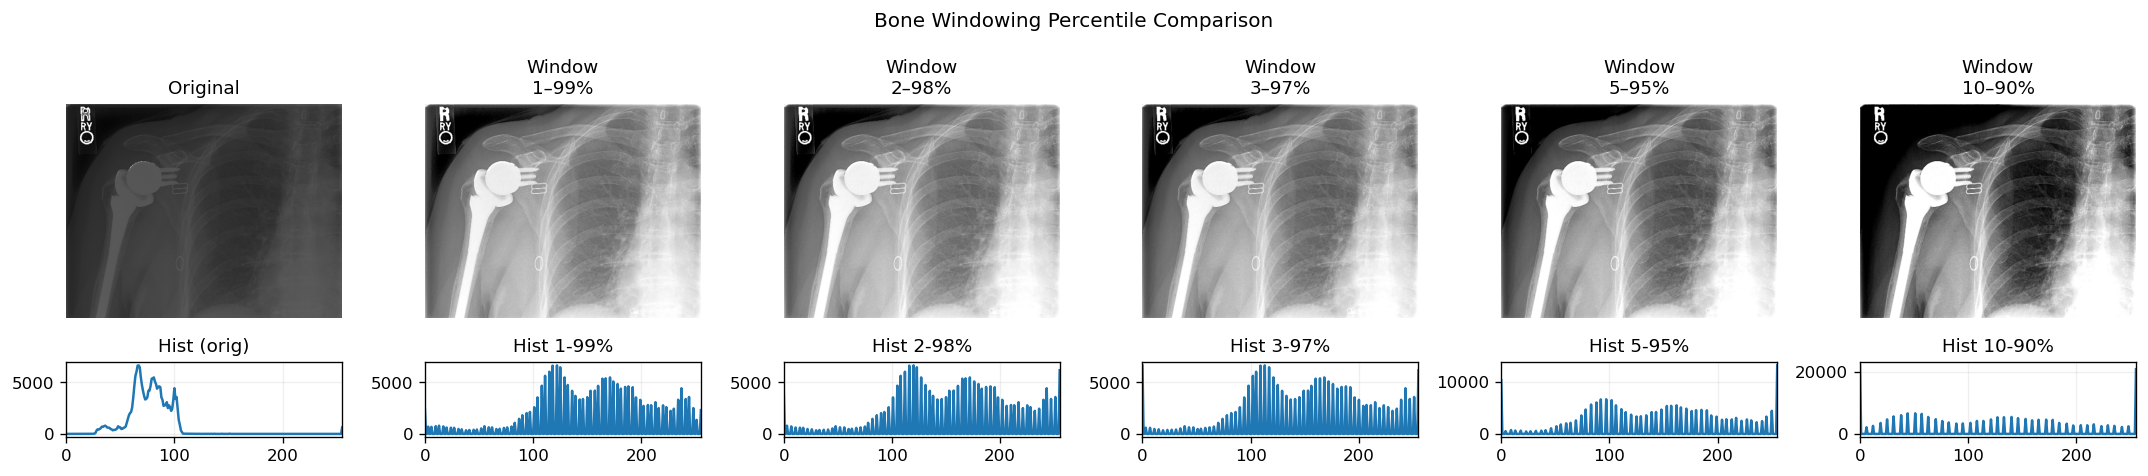

Edge mix sweep…


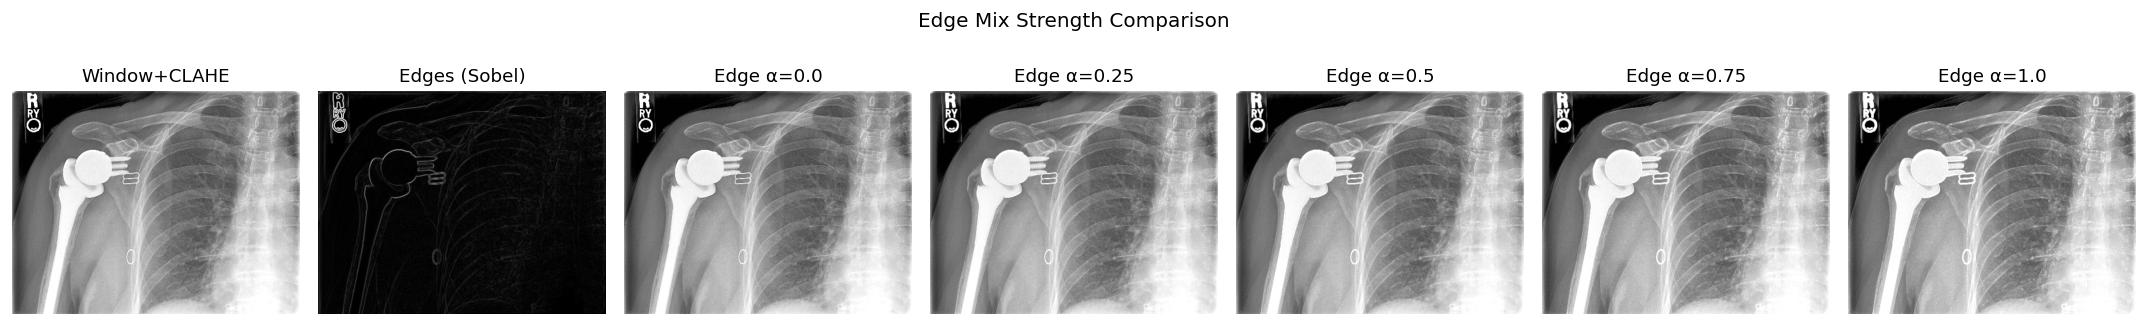

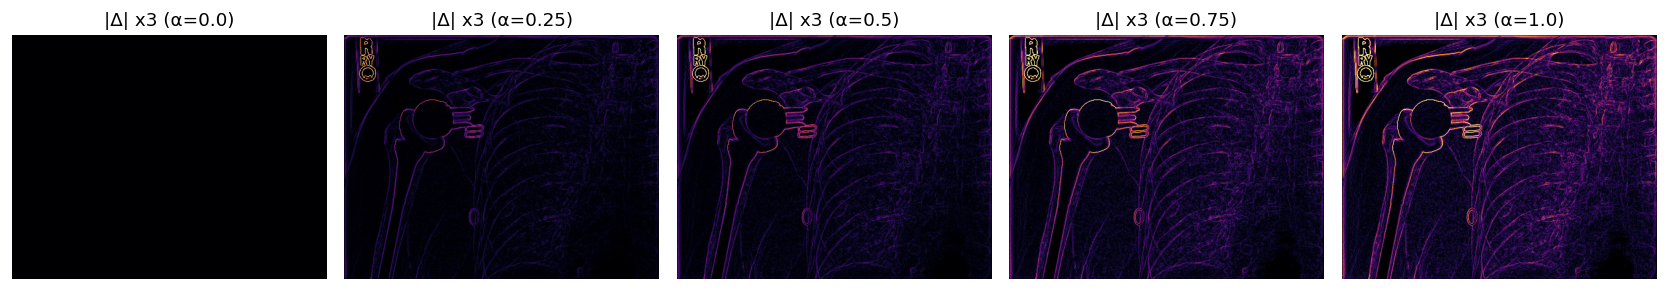

Auto-crop preview…


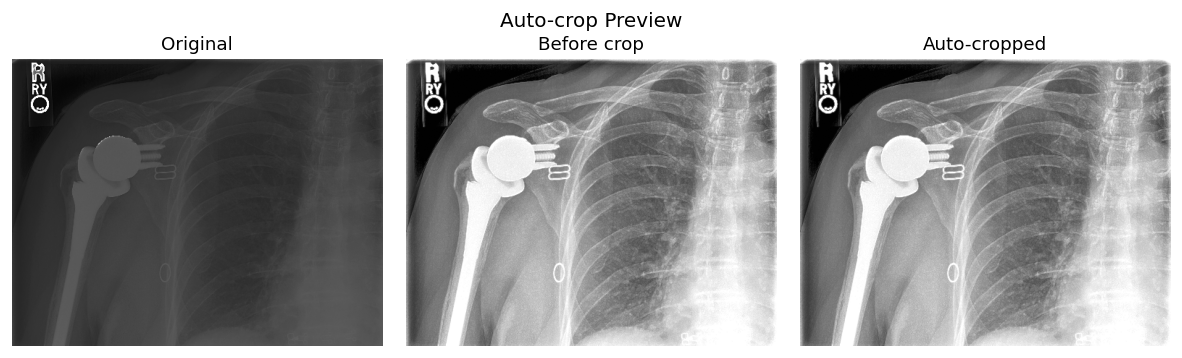

CLAHE sweep…


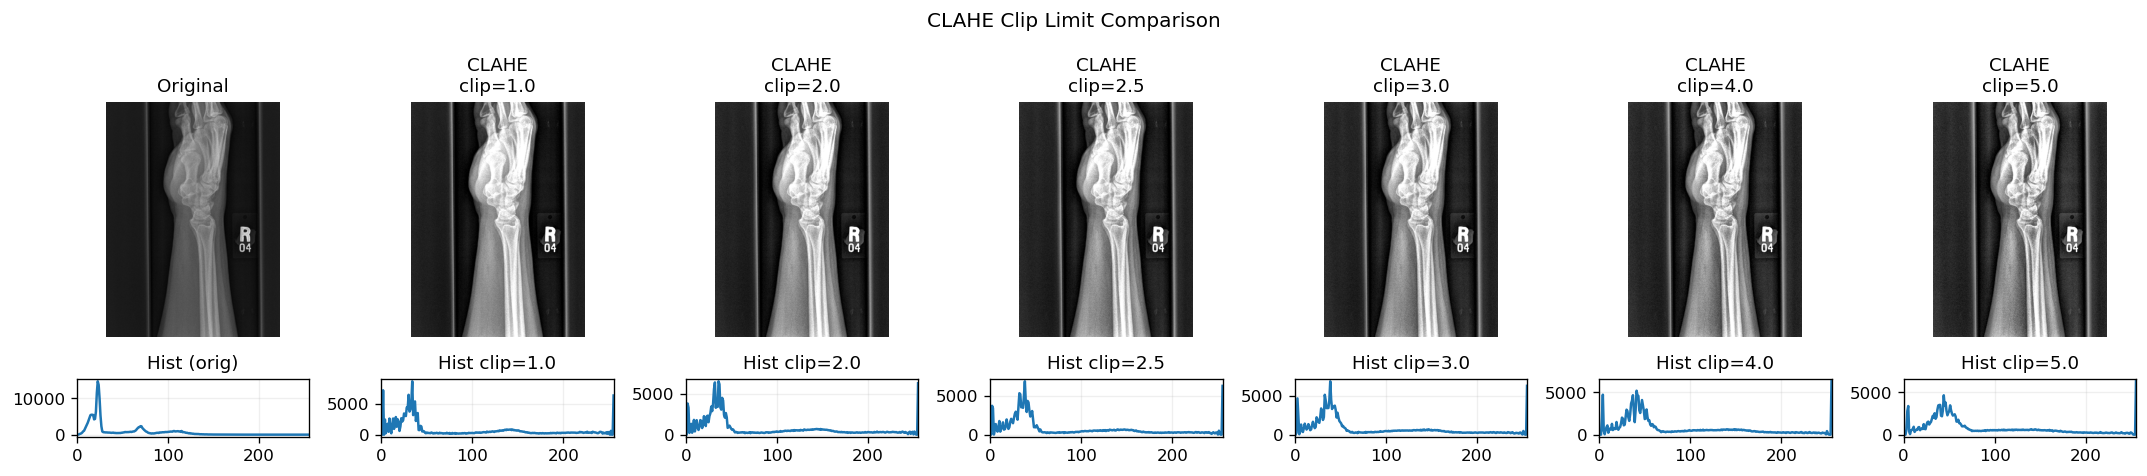

Windowing sweep…


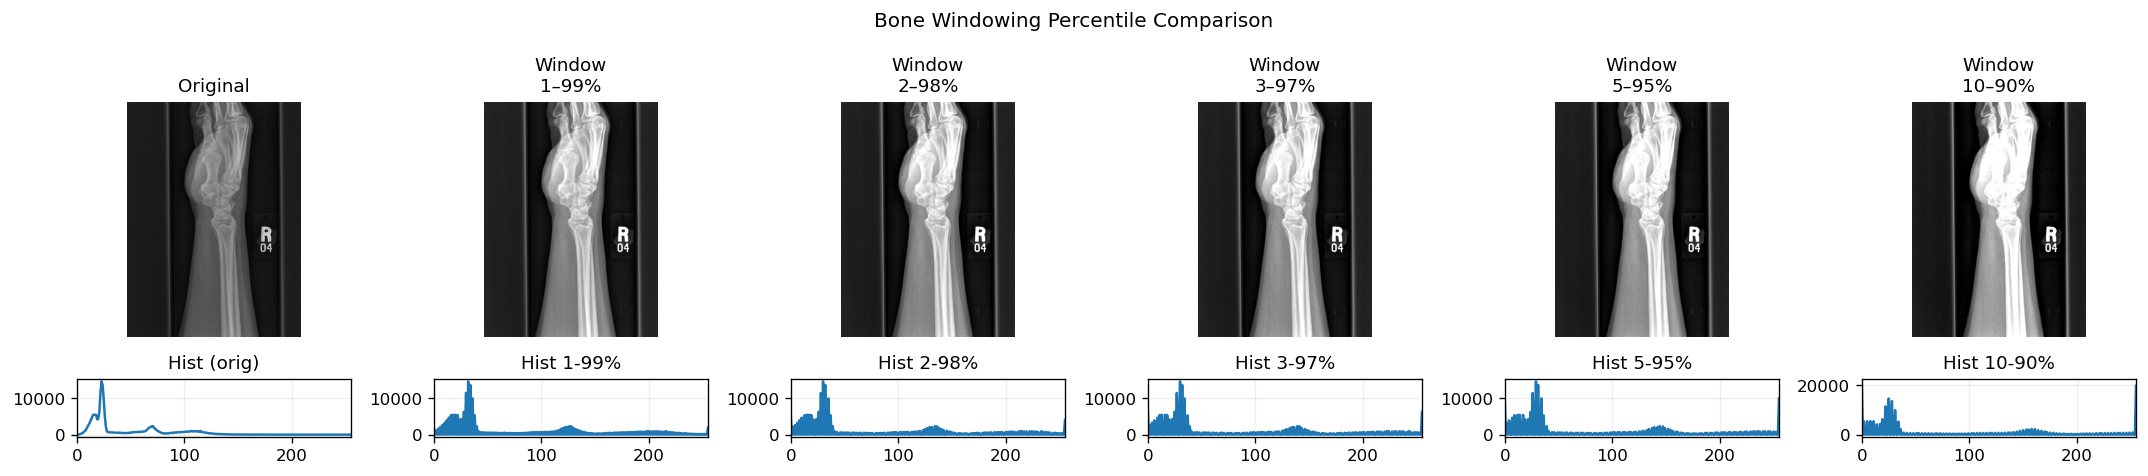

Edge mix sweep…


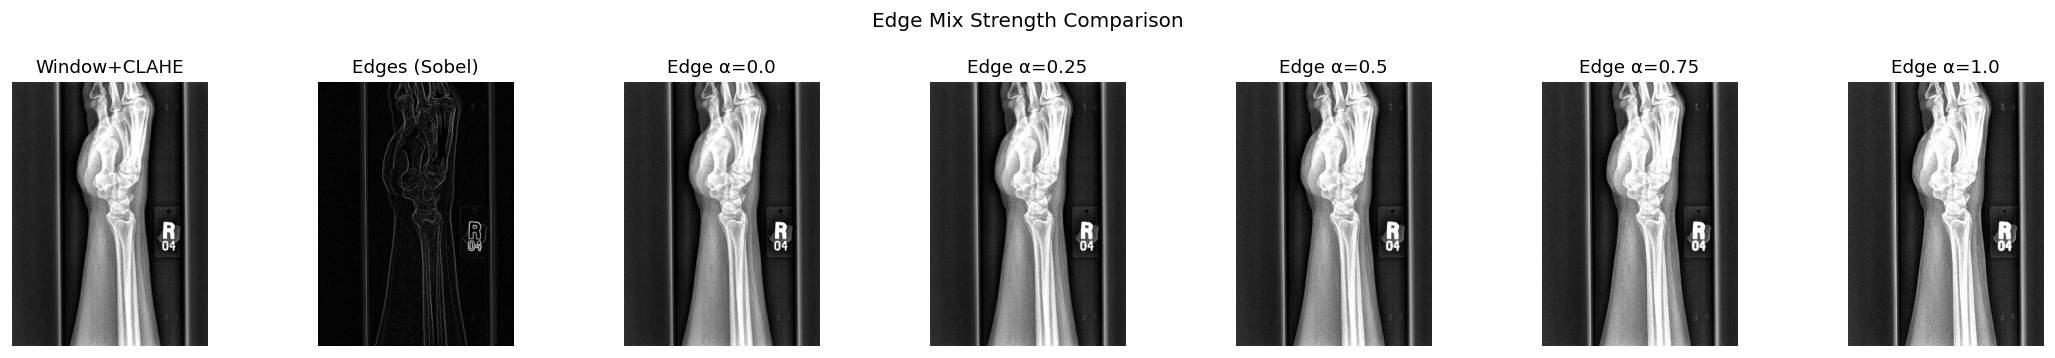

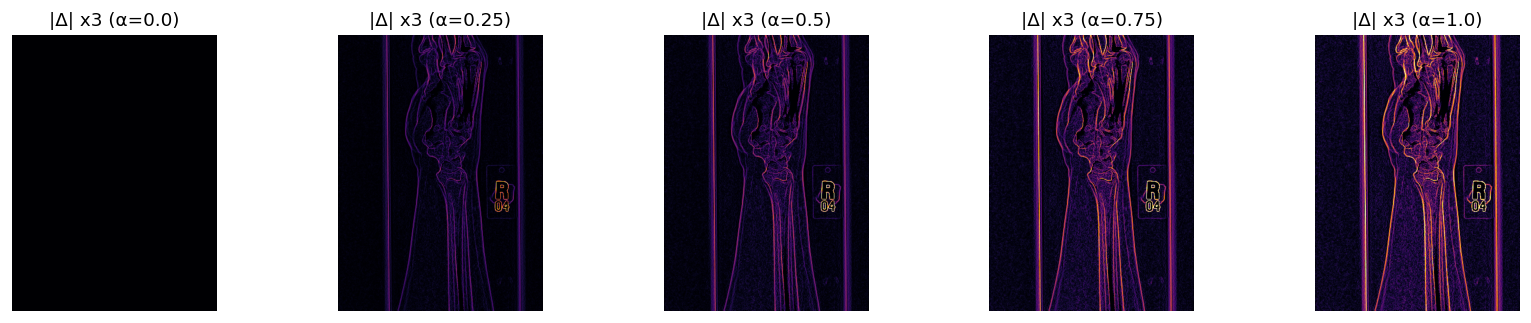

Auto-crop preview…


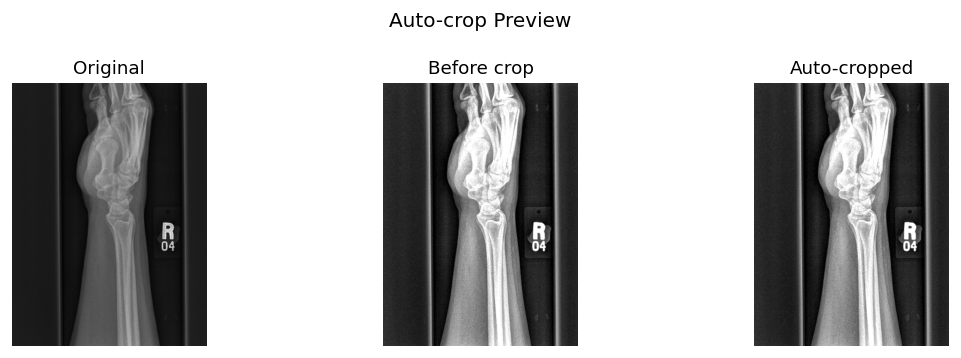

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 11

def safe_imread(path_like):
    """Robust grayscale imread that works with absolute or relative paths."""
    p = Path(path_like)
    if not p.is_file():
        # Some CSVs store relative paths; try under DATA_ROOT
        alt = Path(DATA_ROOT)/path_like
        if alt.is_file():
            p = alt
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
      # print('f"Could not read image: {path_like}"')
        raise FileNotFoundError(f"Could not read image: {path_like}")
    return img

def show_hist(ax, img, title="Histogram"):
    hist = cv2.calcHist([img],[0],None,[256],[0,256]).ravel()
    ax.plot(hist, lw=1.5)
    ax.set_xlim(0,255); ax.set_title(title); ax.grid(True, alpha=0.2)

def show_diff(ax, a, b, title="|Δ| x3"):
    """Visualize absolute difference (amplified) to reveal subtle changes."""
    d = (np.abs(a.astype(np.int16)-b.astype(np.int16))*3).clip(0,255).astype(np.uint8)
    ax.imshow(d, cmap="inferno")
    ax.set_title(title); ax.axis("off")

class BoneWindowTransform:
    """Percentile-based windowing to emphasize bone range."""
    def __init__(self, lower_percentile=3, upper_percentile=97):
        self.lp = lower_percentile
        self.hp = upper_percentile
    def __call__(self, img_np):
        f = img_np.astype(np.float32)
        nz = f[f > 0]
        if nz.size == 0: return img_np
        p_low  = np.percentile(nz, self.lp)
        p_high = np.percentile(nz, self.hp)
        if p_high <= p_low: return img_np
        w = np.clip(f, p_low, p_high)
        w = ((w - p_low) / (p_high - p_low) * 255.0).astype(np.uint8)
        return w

class ClaheTransform:
    """Local contrast enhancement."""
    def __init__(self, clip_limit=2.5, tile_grid_size=(8,8)):
        self.clip_limit = clip_limit
        self.tile = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    def __call__(self, img_np):
        return self.clahe.apply(img_np.astype(np.uint8))

class EdgeTransform:
    """Add a fraction of Sobel edge magnitude back to the image."""
    def __init__(self, alpha=0.5):
        self.alpha = float(alpha)
    def __call__(self, img_np):
        img = img_np.astype(np.float32)
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx*gx + gy*gy)
        mag = (mag / (mag.max() + 1e-6)) * 255.0
        out = np.clip(img + self.alpha*mag, 0, 255).astype(np.uint8)
        return out

class AutoCropTransform:
    """Tightly crop to the largest foreground contour; fallback to original if empty."""
    def __init__(self, thresh=5):
        self.thresh = thresh
    def __call__(self, img_np):
        _, bw = cv2.threshold(img_np, self.thresh, 255, cv2.THRESH_BINARY)
        cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts: return img_np
        x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
        if w < 16 or h < 16: return img_np
        return img_np[y:y+h, x:x+w]
# ----- A) CLAHE clip-limit sweep (like your figure) -----
def clahe_sweep(idx=0, clips=(1.0, 2.0, 2.5, 3.0, 4.0, 5.0), tile=(8,8)):
    path = train_df.loc[idx, "path"]
    raw  = safe_imread(path)
    base = BoneWindowTransform(3,97)(raw)  # mild normalization first

    n = len(clips) + 1
    fig, axes = plt.subplots(2, n, figsize=(18, 4), gridspec_kw={"height_ratios":[4,1]})
    axes[0,0].imshow(raw, cmap="gray"); axes[0,0].set_title("Original"); axes[0,0].axis("off")
    show_hist(axes[1,0], raw, "Hist (orig)")

    for i, cl in enumerate(clips, start=1):
        out = ClaheTransform(cl, tile)(base)
        axes[0,i].imshow(out, cmap="gray")
        axes[0,i].set_title(f"CLAHE\nclip={cl}")
        axes[0,i].axis("off")
        show_hist(axes[1,i], out, f"Hist clip={cl}")

    plt.suptitle("CLAHE Clip Limit Comparison")
    plt.tight_layout(); plt.show()

# ----- B) Bone windowing sweep -----
def window_sweep(idx=0, ranges=((1,99),(2,98),(3,97),(5,95),(10,90))):
    path = train_df.loc[idx, "path"]
    raw  = safe_imread(path)

    n = len(ranges) + 1
    fig, axes = plt.subplots(2, n, figsize=(18, 4), gridspec_kw={"height_ratios":[4,1]})
    axes[0,0].imshow(raw, cmap="gray"); axes[0,0].set_title("Original"); axes[0,0].axis("off")
    show_hist(axes[1,0], raw, "Hist (orig)")

    for i, (lp,hp) in enumerate(ranges, start=1):
        out = BoneWindowTransform(lp, hp)(raw)
        axes[0,i].imshow(out, cmap="gray")
        axes[0,i].set_title(f"Window\n{lp}–{hp}%")
        axes[0,i].axis("off")
        show_hist(axes[1,i], out, f"Hist {lp}-{hp}%")

    plt.suptitle("Bone Windowing Percentile Comparison")
    plt.tight_layout(); plt.show()

# ----- C) Edge mix sweep (also show edge map & difference) -----
def edge_sweep(idx=0, alphas=(0.0, 0.25, 0.5, 0.75, 1.0)):
    path = train_df.loc[idx, "path"]
    raw  = safe_imread(path)
    base = ClaheTransform(2.5,(8,8))(BoneWindowTransform(3,97)(raw))

    # prepare edge magnitude for display
    gx = cv2.Sobel(base.astype(np.float32), cv2.CV_32F, 1, 0, 3)
    gy = cv2.Sobel(base.astype(np.float32), cv2.CV_32F, 0, 1, 3)
    mag = np.sqrt(gx*gx+gy*gy); mag = (mag/(mag.max()+1e-6)*255).astype(np.uint8)

    n = len(alphas) + 2
    fig, axes = plt.subplots(1, n, figsize=(18,3))
    axes[0].imshow(base, cmap="gray"); axes[0].set_title("Window+CLAHE"); axes[0].axis("off")
    axes[1].imshow(mag,  cmap="gray"); axes[1].set_title("Edges (Sobel)"); axes[1].axis("off")

    for i, a in enumerate(alphas, start=2):
        out = EdgeTransform(a)(base)
        axes[i].imshow(out, cmap="gray")
        axes[i].set_title(f"Edge α={a}")
        axes[i].axis("off")

    plt.suptitle("Edge Mix Strength Comparison")
    plt.tight_layout(); plt.show()

    # difference maps (optional but very telling)
    fig, axes = plt.subplots(1, len(alphas), figsize=(14,2.8))
    for i, a in enumerate(alphas):
        out = EdgeTransform(a)(base)
        show_diff(axes[i], base, out, title=f"|Δ| x3 (α={a})")
    plt.tight_layout(); plt.show()

# ----- D) Auto-crop preview -----
def autocrop_preview(idx=0, thresh=5):
    path = train_df.loc[idx, "path"]
    raw  = safe_imread(path)
    pre  = EdgeTransform(0.5)(ClaheTransform(2.5,(8,8))(BoneWindowTransform(3,97)(raw)))
    crop = AutoCropTransform(thresh)(pre)

    fig, axes = plt.subplots(1,3, figsize=(10,3))
    axes[0].imshow(raw, cmap="gray"); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(pre, cmap="gray"); axes[1].set_title("Before crop"); axes[1].axis("off")
    axes[2].imshow(crop, cmap="gray"); axes[2].set_title("Auto-cropped"); axes[2].axis("off")
    plt.suptitle("Auto-crop Preview")
    plt.tight_layout(); plt.show()
def review_all_transforms(idx=0):
    print("CLAHE sweep…");           clahe_sweep(idx)
    print("Windowing sweep…");       window_sweep(idx)
    print("Edge mix sweep…");        edge_sweep(idx)
    print("Auto-crop preview…");     autocrop_preview(idx)
for i in range(3):
  review_all_transforms(idx=i)    # or 1, 2, … try both positive/negative studies


In [ ]:
# ================================================================
# 5) Torch transforms & Dataset
# ================================================================
to_tensor_eval = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

to_tensor_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15, fill=0),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


class MuraDataset(Dataset):
    def __init__(self, df, augment=False):
        """
        Filters out AppleDouble files (prefix '._'), hidden files, missing files,
        and non-image extensions at construction time so the loader never
        touches them. If a '._foo.png' exists but 'foo.png' is present, we
        transparently swap to the real file.
        """
        self.augment = augment
        VALID_EXTS = {".png", ".jpg", ".jpeg"}

        paths = df["path"].astype(str).tolist()
        labels = df["label"].astype(int).tolist()

        good_paths, good_labels = [], []
        dropped, repaired = 0, 0

        for p, y in zip(paths, labels):
            name = os.path.basename(p)
            ext  = os.path.splitext(name)[1].lower()

            # skip hidden or wrong extension
            if name.startswith(".") or name.startswith("._") or ext not in VALID_EXTS:
                # try repair: if '._foo.png' and 'foo.png' exists, use it
                if name.startswith("._"):
                    candidate = os.path.join(os.path.dirname(p), name[2:])
                    if os.path.isfile(candidate):
                        good_paths.append(candidate)
                        good_labels.append(y)
                        repaired += 1
                        continue
                dropped += 1
                continue

            # keep only files that actually exist
            if os.path.isfile(p):
                good_paths.append(p)
                good_labels.append(y)
            else:
                # also try the repair in case the df had a '._' but we filtered it above
                if name.startswith("._"):
                    candidate = os.path.join(os.path.dirname(p), name[2:])
                    if os.path.isfile(candidate):
                        good_paths.append(candidate)
                        good_labels.append(y)
                        repaired += 1
                    else:
                        dropped += 1
                else:
                    dropped += 1

        if dropped or repaired:
            print(f"[MuraDataset] kept {len(good_paths)} | dropped {dropped} | repaired {repaired}")

        # store compact lists for fast indexing
        self.paths  = good_paths
        self.labels = good_labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]

        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # ultra-defensive fallback: if '._foo' slipped through and 'foo' exists, try it once
            base = os.path.basename(p)
            if base.startswith("._"):
                alt = os.path.join(os.path.dirname(p), base[2:])
                if os.path.isfile(alt):
                    img = cv2.imread(alt, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Could not read: {p}")

        # your existing preprocessing chain
        img = preprocess_chain(img)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

        # make 3 channels then apply your train/eval tensor transform
        img3 = np.stack([img, img, img], axis=-1)
        tfm  = to_tensor_train if self.augment else to_tensor_eval
        x    = tfm(img3)
        return x, y


train_ds    = MuraDataset(train_df, augment=True)
valid_ds    = MuraDataset(valid_df, augment=False)

# class-balanced sampler for training
cls_counts   = Counter(train_df["label"].tolist())
total_train  = sum(cls_counts.values())
class_weight = {c: total_train / (len(cls_counts) * n) for c, n in cls_counts.items()}
sample_weights = [class_weight[y] for y in train_df["label"].tolist()]
sampler      = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,   num_workers=0, pin_memory=False)



In [ ]:
# ================================================================
# 6) Model (ResNet50 / DenseNet121), loss, optimizer, scheduler
# ================================================================
def build_model(name="resnet50", num_classes=2):
    name = name.lower()
    if name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, num_classes)
        )
    elif name == "densenet121":
        m = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_features = m.classifier.in_features
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError("MODEL_NAME must be 'resnet50' or 'densenet121'")
    return m

model = build_model(MODEL_NAME, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=3,
    threshold=1e-3,
    cooldown=1,
    min_lr=1e-6,
    verbose=True
)


In [ ]:
# ================================================================
# 7) Checkpoint helpers (auto-resume)
# ================================================================
def get_rng_state():
    return {
        "py_random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch_cpu": torch.get_rng_state().tolist(),
        "torch_cuda": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }

def set_rng_state(st):
    try: random.setstate(st["py_random"])
    except Exception: pass
    try: np.random.set_state(st["np_random"])
    except Exception: pass
    try: torch.set_rng_state(torch.tensor(st["torch_cpu"], dtype=torch.uint8))
    except Exception: pass
    if torch.cuda.is_available() and st.get("torch_cuda") is not None:
        try: torch.cuda.set_rng_state_all(st["torch_cuda"])
        except Exception: pass

def atomic_save(state, path):
    tmp = str(path) + ".tmp"
    torch.save(state, tmp)
    os.replace(tmp, path)

def save_history_json(history_dict, path=HISTORY_JSON):
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(history_dict, f, indent=2)
    except Exception as e:
        print(f"[warn] could not write {path}: {e}")

def save_checkpoint(epoch_idx, best_val, history):
    state = {
        "epoch": epoch_idx,
        "model_name": MODEL_NAME,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_val": best_val,
        "history": history,
        "rng_state": get_rng_state(),
        "device_info": str(DEVICE),
    }
    atomic_save(state, LATEST_CKPT)
    save_history_json(history)

from pathlib import Path
from typing import Union, Optional, Tuple

def try_load_checkpoint(
    source: Union[int, str, Path, None] = "latest",
    *,
    load_optimizer: bool = True,
    load_scheduler: bool = True,
    load_rng: bool = True,
    strict_model_name: bool = True,
) -> Optional[Tuple[int, float, dict]]:
    """
    Load a checkpoint for resume/inference from:
      - "latest" (default): uses LATEST_CKPT
      - int (e.g., 100): uses CHECKPOINT_DIR/epoch_100/epoch_100.pt
      - str/Path: explicit path to a .pt file

    Returns:
        (start_epoch, best_val, history) on success, else None
    """
    # Resolve the checkpoint path
    if source in (None, "latest"):
        ckpt_path = LATEST_CKPT
        pretty = f"{ckpt_path} (latest)"
    elif isinstance(source, int):
        snap_dir = CHECKPOINT_DIR / f"epoch_{source:03d}"
        ckpt_path = snap_dir / f"epoch_{source:03d}.pt"
        pretty = f"{ckpt_path} (epoch {source:03d})"
    else:
        ckpt_path = Path(source)
        pretty = str(ckpt_path)

    # Existence check
    if not ckpt_path.exists():
        print(f"[warn] Checkpoint not found: {ckpt_path}")
        return None

    print(f"Found checkpoint: {pretty}, loading …")
    ckpt = torch.load(ckpt_path, map_location=DEVICE)

    # Optional model-name guard
    src_name = (ckpt.get("model_name") or "").lower()
    cur_name = (MODEL_NAME or "").lower()
    if strict_model_name and src_name != cur_name:
        print(f"[warn] Checkpoint model '{ckpt.get('model_name')}' != current '{MODEL_NAME}'. Skipping resume.")
        return None

    # Always load model weights
    model.load_state_dict(ckpt["model_state"])

    # Optionally restore optimizer/scheduler to continue training
    if load_optimizer and "optimizer_state" in ckpt and ckpt["optimizer_state"] is not None:
        try:
            optimizer.load_state_dict(ckpt["optimizer_state"])
        except Exception as e:
            print(f"[warn] optimizer state not restored: {e}")

    if load_scheduler and scheduler is not None and ckpt.get("scheduler_state") is not None:
        try:
            scheduler.load_state_dict(ckpt["scheduler_state"])
        except Exception as e:
            print(f"[warn] scheduler state not restored: {e}")

    # Optionally restore RNG state for reproducible continuation
    if load_rng and ckpt.get("rng_state") is not None:
        set_rng_state(ckpt["rng_state"])

    # Bookkeeping
    start_epoch = int(ckpt.get("epoch", 0)) + 1
    best_val = float(ckpt.get("best_val", float("inf")))
    hist = ckpt.get("history", defaultdict(list))
    # Ensure plain dict for JSON-serializable history
    if isinstance(hist, defaultdict):
        hist = dict(hist)

    print(f"Resume at epoch {start_epoch} (best_val={best_val if best_val != float('inf') else float('inf'):.4f})")
    return start_epoch, best_val, hist


In [ ]:
# ================================================================
# 8) Training with ONE tqdm bar per epoch + auto-resume
#    – force plain tqdm to avoid nested bars on Windows/Jupyter
# ================================================================
import sys, time, random, json, torch, numpy as np
from collections import defaultdict

# --- CHANGED: remove notebook auto-backend and force plain tqdm ---
from tqdm import tqdm
_TQDM_KW = dict(               # choose defaults that match your desired output
    dynamic_ncols=True,        # adjusts width nicely
    leave=True,                # keep one finished bar per epoch
    position=0,                # always reuse the same console line
    file=sys.stdout            # avoids ghost lines on Windows
)
# -----------------------------------------------------------------

def train_one_epoch(epoch_idx: int, global_step: int = 0):
    tr_loss_sum = tr_correct = tr_seen = 0
    va_loss_sum = va_correct = va_seen = 0

    total_steps = len(train_loader) + len(valid_loader)
    pbar = tqdm(total=total_steps, desc=f"Epoch {epoch_idx}/{EPOCHS}",
                mininterval=0.2, **_TQDM_KW)

    # -------------------- TRAIN --------------------
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        tr_loss_sum += loss.item() * bs
        tr_correct  += (logits.argmax(1) == yb).sum().item()
        tr_seen     += bs
        global_step += 1

        pbar.set_postfix({
            "phase": "train",
            "loss": f"{tr_loss_sum/max(1,tr_seen):.4f}",
            "acc":  f"{tr_correct/max(1,tr_seen):.4f}"
        }, refresh=False)
        pbar.update(1)

        if SAVE_EVERY_STEPS > 0 and (global_step % SAVE_EVERY_STEPS == 0):
            save_checkpoint(epoch_idx=epoch_idx, best_val=best_val, history=history)

    # -------------------- VALID --------------------
    model.eval()
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            loss   = criterion(logits, yb)

            bs = xb.size(0)
            va_loss_sum += loss.item() * bs
            va_correct  += (logits.argmax(1) == yb).sum().item()
            va_seen     += bs

            pbar.set_postfix({
                "phase": "valid",
                "loss": f"{va_loss_sum/max(1,va_seen):.4f}",
                "acc":  f"{va_correct/max(1,va_seen):.4f}"
            }, refresh=False)
            pbar.update(1)

    pbar.close()

    tr_loss = tr_loss_sum / max(1, tr_seen)
    tr_acc  = tr_correct  / max(1, tr_seen)
    va_loss = va_loss_sum / max(1, va_seen)
    va_acc  = va_correct  / max(1, va_seen)
    return tr_loss, tr_acc, va_loss, va_acc, global_step


# ---------------- history / resume bookkeeping ----------------
history     = defaultdict(list)
best_val    = float("inf")
no_improve  = 0
start_epoch = 1
global_step = 0

resume_bundle = try_load_checkpoint("latest")#try_load_checkpoint() if RESUME else None
if resume_bundle is not None:
    start_epoch, best_val, loaded_history = resume_bundle
    for k, v in loaded_history.items():
        history[k] = v if isinstance(v, list) else list(v)

print("Training…")
for current_epoch in range(start_epoch, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc, va_loss, va_acc, global_step = train_one_epoch(
        epoch_idx=current_epoch, global_step=global_step
    )

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    if scheduler is not None:
        scheduler.step(va_loss)

    save_checkpoint(epoch_idx=current_epoch, best_val=best_val, history=history)

    # Save checkpoint every N epochs into its own folder
    check_point_at = 10
    if current_epoch % check_point_at == 0:
        snapshot_dir = CHECKPOINT_DIR / f"epoch_{current_epoch:03d}"
        snapshot_dir.mkdir(parents=True, exist_ok=True)

        snapshot_path = snapshot_dir / f"epoch_{current_epoch:03d}.pt"  # file
        state = {
            "epoch": current_epoch,
            "model_name": MODEL_NAME,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
            "best_val": best_val,
            "history": history,
            "rng_state": get_rng_state(),
            "device_info": str(DEVICE),
        }
        torch.save(state, snapshot_path)
        print(f"  ↳ saved snapshot for epoch {current_epoch:03d}: {snapshot_path}")


    saved_msg = ""
    if va_loss < best_val - 1e-6:
        best_val = va_loss
        no_improve = 0
        torch.save(model.state_dict(), BEST_PATH)
        saved_msg = f"  ↳ saved best: {BEST_PATH.name}"
    else:
        no_improve += 1

    print(
        f"Epoch {current_epoch:02d}: "
        f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
        f"val_loss={va_loss:.4f} acc={va_acc:.4f} | "
        f"time={time.time()-t0:.1f}s{saved_msg} " # Fixed: Changed | to + for string concatenation
        f"lr={optimizer.param_groups[0]['lr']:.6f}"
    )

[warn] Checkpoint not found: C:\Users\NaralaG3762\Downloads\MURA-v1.1\MURA-v1.1\AA_v3 testing_t1_dml_runs\checkpoints\latest.pt
Training…
Epoch 1/500: 100%|███████████| 484/484 [06:21<00:00,  1.27it/s, phase=valid, loss=0.5973, acc=0.6950]
Epoch 01: train_loss=0.6069 acc=0.6883 | val_loss=0.5973 acc=0.6950 | time=381.9s  ↳ saved best: resnet50_best.pt lr=0.000300
Epoch 2/500: 100%|███████████| 484/484 [06:18<00:00,  1.28it/s, phase=valid, loss=0.7062, acc=0.6806]
Epoch 02: train_loss=0.5735 acc=0.7335 | val_loss=0.7062 acc=0.6806 | time=379.0s lr=0.000300
Epoch 3/500: 100%|███████████| 484/484 [06:21<00:00,  1.27it/s, phase=valid, loss=0.6050, acc=0.7210]
Epoch 03: train_loss=0.5536 acc=0.7519 | val_loss=0.6050 acc=0.7210 | time=382.0s lr=0.000300
Epoch 4/500: 100%|███████████| 484/484 [06:21<00:00,  1.27it/s, phase=valid, loss=0.5841, acc=0.7341]
Epoch 04: train_loss=0.5475 acc=0.7574 | val_loss=0.5841 acc=0.7341 | time=382.1s  ↳ saved best: resnet50_best.pt lr=0.000300
Epoch 5/500: 1